# N-grams, Fastttext, and GloVE

*This assignment focuses on exploring Fasttext and GloVE as NLP methods. We are going to focus on two tasks and ways of understanding models:*

1. *The traditional, "model is a classifier" viewpoint. Here we are going to work with the [AG News Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) to classify genres*
2. *The more vector-based way, seeing them basically as machines that just generate word vectors, with everything else just being gravy. Barring attaching a specific classifier, GloVE falls entirely under this category.* 

*In this assignment, we are mainly going to be using the [AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset), a corpus of more than 1 million news articles, each classified as one of four classes: 'Business', 'Sci/Tech', 'World', or 'Sports'. Note, that because of the semi-supervised nature of most methods used in this assignment, we could almost do the whole thing without the labels. They're just there to make it a bit simpler and to provide an obvious usecase.*

**For the GloVe part, note that you can download all their pretrained vectors at the [GloVe project page](https://nlp.stanford.edu/projects/glove/).**

## 0. Extra primer on Fasttext

*As you know, n-grams are pretty useful for improving the otherwise limited bag-of-words (BoW) model. Most often, this is by making distinctions between sentences such as "good" and "not good" which would be represented somewhat the same in a regular BoW. It is very obvious if we consider the sentence "Maria stole the milk" vs "The milk stole Maria", two sentences completely identical in the BoW representation, but with two obviously different meanings.*

*As you also know, Fasttext takes this further by creating chracter-wise n-grams. These are made up of n-characters of a single word. This allows fasttext to consider cases such as grammar, where words are spelled similarly and even consider misspellings, if someone makes a mistaek in wirtign a wrod, the character-wise n-gram representation will be **almost** the same as the correct word.*

This is done by Fasttext simply storing embedding vectors $v_n$ for each n-gram, character or otherwise. Fasttext will simply then average all of these vectors, word, character-wise n-grams, and word-wise n-grams to create the representation for a given text or sentence.

$$v_{total} = \frac{1}{N}\sum^N_{n=0} v_n$$

### Important note: Fasttext supervised and unsupervised

*If you look into the technical documentation for the fasttext model, you'll notice that there are options to train both an **unsupervised** and a **supervised** version of the fasttext model. These use similar approaches, but it is arguably the unsupervised model that best describes what the fasttext team wanted to accomplish: efficient word-vector generation for downstream usage.*

***The supervised model:***
- *Needs a corpus of text with given labels to train*
- *Does not use skipgram/CBoW, but just works as a 'normal' FFN for classification*
- *Uses character-wise n-grams*
- *Uses word-wise n-grams the same way as the unsupervised model uses character-wise n-grams, treating them as vectors and combining them in the end for the final classification.*
- *Can be directly evaluated by just checking how good it is at predicting the given classes.*

***The unsupervised model:*** (not important for this assignment or course, just cool to know)
- *Just needs a corpus of text to train*
- *Does not use wordwise n-grams*
- *Has vectors for each unique character n-gram and each unique word in the corpus (limited by bin size)* 
- *Vectors for character n-grams are created indepedently of word vectors, for example the trigram "her" present in "where" has a different vector representation than the one for the full word "her".*
- *Is a purely skipgram/CBoW model (input layer, one hidden, output layer)*
- *Cannot be directly evaluated except in qualitative ways by considering the downstream tasks it will be used in*


***Both models***
- *Only work on CPU (bvadr) (what a time 2015 was!)*

In [1]:
import numpy as np
import string
import random
import re
import pickle
import fasttext

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from tqdm import tqdm
import torch

In [2]:
def generate_seed():
    """
    Generates robust seed values using methods adapted from Gaius-quantum reverse...
    ...GaunTLets, see more https://isotropic.org/papers/chicken.pdf and explained https://www.youtube.com/watch?v=dQw4w9WgXcQ
    Values are generated from a specific subset of alphanumerics representing sub-deca natural-numericals
    from the glove.42B.300d.txt Use this subset for the reverse function as well, the whole one will take too long
    """

    with open("data/important_stuff.pkl", "rb") as fp:
        GQRGaunTLets_69B_300_seed_vals = pickle.load(fp)
        seed = int(np.var(GQRGaunTLets_69B_300_seed_vals[69]) * 100)
        return seed

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    try: torch.manual_seed(seed_value)
    except: pass

seed_everything(generate_seed())

## Exercise 1 Word- and character-wise n-grams

*The selling point of fasttext is in part given by its main paper's name: **Enriching Word Vectors with Subword Information**.  Character n-grams is really all its about. Since you have already worked with them, we are just going to briefly introduce them*

*Normally, getting N-grams would be something you'd leave for an NLP package like NLTK. We're just going to implement it for the sake of understanding.*

**1. Implement the below functions to get word-grams and character-grams respectively**

In [3]:
# N-gram functions -  Might need to be filled by students?

def preprocess_text(text, lower=True, strip=True):
    # Preprocess the text
    if lower:
        text = text.lower()
    if strip:
        text = re.sub('[^A-Za-z0-9 ]+', '', text)
    
    return text

def get_word_grams(text, n, lower=True, strip=True):
    """Gets a specific n-gram for a given text string"""

    text = preprocess_text(text, lower, strip)
    
    length = len(text.split())

    # Add padding
    pad_start = ' '.join(["<s>"]*(n-1)) + ' '
    pad_end = ' ' + ' '.join(["</s>"]*(n-1))
    text = pad_start + text + pad_end

    n_grams = []
    text = text.split()
    
    # Obtain N-grams
    for i in range(length + n-1):
        n_grams.append(' '.join(text[i:i+n]))

    return n_grams

def get_character_grams(word: str, n):
    """Gets the character wise n-grams for a single word"""
    word_grams = []

    word = preprocess_text(word)

    word = '<' + word + '>'

    # Obtain character-grams
    for i in range(len(word) - n + 1):
        word_grams.append(word[i:i+n])

    return word_grams

In [4]:
text = "He turned himself into a pickle... Funniest shit, ive ever seen!!!"

n_grams = get_word_grams(text, n=4, lower=True, strip=True)
print(n_grams)

['<s> <s> <s> he', '<s> <s> he turned', '<s> he turned himself', 'he turned himself into', 'turned himself into a', 'himself into a pickle', 'into a pickle funniest', 'a pickle funniest shit', 'pickle funniest shit ive', 'funniest shit ive ever', 'shit ive ever seen', 'ive ever seen </s>', 'ever seen </s> </s>', 'seen </s> </s> </s>']


*As you can see from running the example below, even in this very small sentence, there are a ton of n-grams, and even more word-grams. This is why, for practical purposes, the Fasttext model often operates on what is known as a **'bucket size'** which defines the maximum number of possible word-grams avaliable in the model.*

In [5]:
# Now let us just test these functions on some toy text...
text = "He turned himself into a pickle... Funniest shit, ive ever seen!!!"

n_grams = get_word_grams(text, n=3, lower=True, strip=True)
# word_grams = [get_character_grams(words[0], n=3) for words in n_grams]
# print(get_character_grams(text, n=3))
# print([preprocess_text(word) for word in text.split()])
word_grams = [get_character_grams(word, n=3) for word in text.split()]

print("Word-grams here: \n ", n_grams)

print("Character-grams here: \n ", word_grams)

Word-grams here: 
  ['<s> <s> he', '<s> he turned', 'he turned himself', 'turned himself into', 'himself into a', 'into a pickle', 'a pickle funniest', 'pickle funniest shit', 'funniest shit ive', 'shit ive ever', 'ive ever seen', 'ever seen </s>', 'seen </s> </s>']
Character-grams here: 
  [['<he', 'he>'], ['<tu', 'tur', 'urn', 'rne', 'ned', 'ed>'], ['<hi', 'him', 'ims', 'mse', 'sel', 'elf', 'lf>'], ['<in', 'int', 'nto', 'to>'], ['<a>'], ['<pi', 'pic', 'ick', 'ckl', 'kle', 'le>'], ['<fu', 'fun', 'unn', 'nni', 'nie', 'ies', 'est', 'st>'], ['<sh', 'shi', 'hit', 'it>'], ['<iv', 'ive', 've>'], ['<ev', 'eve', 'ver', 'er>'], ['<se', 'see', 'een', 'en>']]


## Exercise 2 Training and using the fasttext model

<p style="text-align:center;">"<i>(Almost) Never do yourself what some other chump has done better"</i> </p>
<p style="text-align:center;"> - Creed of the KID </p>

*Obviously someone else has made a pretty well working [Fasttext module](https://fasttext.cc/). In this case, it is the team at Meta (Facebook, back then). Aside from how well it trains, is does have a few weird things about it, most notably that it requires .txt files to train (bvadr).*

*For this exercise, we are going to focus on just tweaking minn and maxnn which control the minimum and maximum length for the character-grams. Note that setting the minn and maxn length both to 0, makes the model only consider word-grams and word vectors.*

*A complete list of model hyperparameters can be found in the file hypereparams.txt, along with (most) methods callable on the Fasttext model. Refer to this if you need inspiration on making your model interesting. Consider any chosen hyperparamters **as arbitrary** and feel free to change them as you wish. It helps, however, to comment on or argue for your changes.*

*Important note: If the model is asked for a word- or character-vector **not in its current vocabulary**, it will give a zero-vector of the same dimension as the other vectors in its vocabulary. This way even extremely esoteric spelling errors do not 'break' the model due to vocabulary lookup errors, the words themselves will just not add anything to the prediction.*

### Fasttext - Theoretical questions

**1. In general, how does fasttext handle OOV (out of vocabulary) tokens? How do they contribute to embeddings vectors?**

In FastText, OOV tokens are split into character n-grams, for which an embedding can be found individually by looking it up in the subword embedding matrix, which was learned during training. Then all the character n-grams are averaged to obtain an embedding for the full word. 

**2. Say you have a fasttext model trained on a large corpus with character-3-grams how would it reprsent the OOV word "Phandelver"?.**

The model would split the OOV word into subwords, as explained above. For n=3 this would look as such:

<ph, han, and, nde, del, elv, lve, ver, er>

Note: We write a "p" instead of a "P" since the preprocessing lowers all uppercase letters.

**3. In probability theory, you often consider either the marignal probability $p(x)$, or the conditional probability $p(x|y)$. How do these two different kinds of probability relate to the field of natural language processing?**

<p style="text-align:center;"><i>"Words that appear together, relate together"</i></p>
<p style="text-align:center;">- From slides</p>


The marginal probability represents the probability of a word appearing in a corpus of text and it is calculated by dividing the amount of times the word occurs divided by the total amount of words in the corpus.

However the condition probability represents the probability of words appearing in succession. Among other applications, this can help us predict the next word based on the previous word.

For instance, suppose y denotes an arbitrary word, and x denotes the word following y. In this case, the conditional probability $p(x|y)$ represents the probability that the word following y is x. Hence by maximizing the conditional probability, we can predict the next word in a sentence based on the previous word. Auto-correct in phones is a great example of this.

<!-- The marginal probability relates to the number of times a word appears in a corpus, while the conditional probability is the probability of a word given the previous word. -->


**4. Word2Vec is pretty old method in NLP, now mostly supplanted by attention-based models. What disadvantages are there in using specific word vectors for text classification? As inspiration, consider a fasttext model being given the following question:**

*Mary saw a puppy in the window, she wanted it. James saw a nice window in the window store, he wanted it. What did Mary want?*


Contextual Understanding:
Word2Vec generates static embeddings, meaning that each word has a fixed representation regardless of its context. For example, in the sentence above, Word2Vec might incorrectly associate “it” with “window” rather than “puppy,” as it doesn’t encode the relationship between words in context.

Handling Polysemy:
As words are encoded independant of their context, sometimes words can have multiple meanings, leading to ambiguity.

Out-of-Vocabulary (OOV) Words:
Word2Vec cannot handle words not seen during training, as it requires a pre-trained embedding for each word. In contrast, FastText uses subword (e.g., n-gram) embeddings, enabling it to approximate embeddings for OOV words by combining representations of their subwords.

Storage Requirements:
Word2Vec requires storing an embedding for every word in the vocabulary, which can be computationally expensive for large corpora. FastText, by operating on subword units, reduces storage demands and increases efficiency.


$\star$ **5. As mentioned, attention-based models fix a lot of issues that older Word2Vec models had. Particularly, they do not need N-grams to capture context information. Why is this?**

$\dots$

$\star$ **6. Because of the way fasttext generates word-vectors (skipgram/CBoW), it only ever considers local contexts and not whole corpora at a time. What potential downsides does this have?**

$\dots$

In [6]:
# Load AG_news data
news_data = np.load('./data/news_data.npz', allow_pickle=True)
train_texts = news_data['train_texts']
test_texts = news_data['test_texts']
train_labels = news_data['train_labels']
test_labels = news_data['test_labels']
ag_news_labels = news_data['ag_news_label']

print(f"There are a total of {len(train_labels)} data points in the dataset, \n"
        f"{len(test_texts)} different points in the test set, and the different labels are {np.unique(train_labels)},\n"
        f"these correspond to the categories: {ag_news_labels}\n")


# Let's just ensure class proportions are balanced for both training and testing purposes...
n_classes = len(ag_news_labels)
print("Training class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(train_labels==i))
print()

print("Test class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(test_labels==i))


There are a total of 120000 data points in the dataset, 
7600 different points in the test set, and the different labels are [0 1 2 3],
these correspond to the categories: ['World' 'Sports' 'Business' 'Sci/Tec']

Training class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25

Test class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25


In [7]:
# Creating fasttext data set from current training data
def train_test_split(texts, labels, train_split=0.8):
    """
    Creates .txt files for training and testing, compatible with a fasttext model

    Args:
        texts (np.ndarray): Iterable of full text where one item is one text
        labels (np.ndarray): Labels for full text so that label i corresponds to text i
        train_split (float): Fraction of data to be used for training, rest is used for testing

    Returns:
        train_texts (np.ndarray): Training texts
        train_labels (np.ndarray): Training labels
        test_texts (np.ndarray): Testing texts
        test_labels (np.ndarray): Testing labels
    """

    text_length = len(texts)

    indices = np.arange(text_length)
    np.random.shuffle(indices)

    texts = texts[indices]
    labels = labels[indices]

    train_size = int(text_length * train_split)

    train_texts = texts[:train_size]
    train_labels = labels[:train_size]

    test_texts = texts[train_size:]
    test_labels = labels[train_size:]

    return train_texts, train_labels, test_texts, test_labels 

def txtify_data(texts, labels, label_names, save_path):
    """
    Converts a list of texts and labels to a .txt file compatible with fasttext

    Args:
        texts (np.ndarray): Train texts to be converted to .txt
        labels (np.ndarray): Train labels so that label i corresponds to text i
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
        save_path (str): Path where the txt file will be saved so fasttext can use it

    Returns:
        _type_: _description_
    """

    txt = ""
    for i, (text, label) in tqdm(enumerate(zip(texts, labels))):
        text = text.lower()
        text = re.sub('[^a-z0-9 ]+', '', text)

        txt = txt + f'__label__{label_names[label]} {text}\n'

    
    f = open(save_path, mode='w')
    f.write(txt)
    f.close()

    return save_path

# No need to run if already saved
# path_to_train = txtify_data(train_texts, train_labels, ag_news_labels, save_path='training_data.txt')
# path_to_test = txtify_data(test_texts, test_labels, ag_news_labels, save_path='test_data.txt')
path_to_train = 'training_data.txt'
path_to_test = 'test_data.txt'

In [8]:
# Defining fasttext hyperparameters
char_gram_length_min = 3 # If set to zero, we only train word-grams
char_gram_length_max = 6 # If set to zero, we only train word-grams
num_word_grams = 1 # Default value
verbose = True # Set to false if you don't want to see training statistics

# Train fasttext_word_model and fasttext_char_model respectively
fasttext_word_model = fasttext.train_supervised(path_to_train, maxn=0, minn=0, verbose=verbose,
                                                wordNgrams=num_word_grams)

fasttext_char_model = fasttext.train_supervised(path_to_train, maxn=char_gram_length_max, minn=char_gram_length_min,
                                                verbose=verbose, wordNgrams=num_word_grams)

Read 4M words
Number of words:  91297
Number of labels: 4
Progress: 100.0% words/sec/thread: 4139927 lr:  0.000000 avg.loss:  0.266915 ETA:   0h 0m 0s
Read 4M words
Number of words:  91297
Number of labels: 4
Progress: 100.0% words/sec/thread:  446384 lr:  0.000000 avg.loss:  0.397843 ETA:   0h 0m 0s


In [9]:
# Example of how the subwords of the character model and the word model differ
# get_subwords gets all character-gram 'parts' of the word specified...
# ...as well as indices corresponding to the row of the given vector in the embedding matrix
print("Word model subwords:", fasttext_word_model.get_subwords('cat'))
# Testing with longer word to see min and max n-gram lengths
print("Character model subwords:", fasttext_char_model.get_subwords('supercalifragilisticexplialidocious'))

Word model subwords: (['cat'], array([4525]))
Character model subwords: (['<su', '<sup', '<supe', '<super', 'sup', 'supe', 'super', 'superc', 'upe', 'uper', 'uperc', 'uperca', 'per', 'perc', 'perca', 'percal', 'erc', 'erca', 'ercal', 'ercali', 'rca', 'rcal', 'rcali', 'rcalif', 'cal', 'cali', 'calif', 'califr', 'ali', 'alif', 'alifr', 'alifra', 'lif', 'lifr', 'lifra', 'lifrag', 'ifr', 'ifra', 'ifrag', 'ifragi', 'fra', 'frag', 'fragi', 'fragil', 'rag', 'ragi', 'ragil', 'ragili', 'agi', 'agil', 'agili', 'agilis', 'gil', 'gili', 'gilis', 'gilist', 'ili', 'ilis', 'ilist', 'ilisti', 'lis', 'list', 'listi', 'listic', 'ist', 'isti', 'istic', 'istice', 'sti', 'stic', 'stice', 'sticex', 'tic', 'tice', 'ticex', 'ticexp', 'ice', 'icex', 'icexp', 'icexpl', 'cex', 'cexp', 'cexpl', 'cexpli', 'exp', 'expl', 'expli', 'explia', 'xpl', 'xpli', 'xplia', 'xplial', 'pli', 'plia', 'plial', 'pliali', 'lia', 'lial', 'liali', 'lialid', 'ial', 'iali', 'ialid', 'ialido', 'ali', 'alid', 'alido', 'alidoc', 'lid', '

In [10]:
def test_prediction(model, test_text, test_label=None, return_bool=True):
    """
    test labels and return_bool used for when we need accuracy of the model
    Method for testing fasttext model
    Model should be either the character model or the word model

    Args:
        model (fasttext model): Model to be tested
        test_text (str): Text to be tested
        test_label (str): Label of the text, used for testing accuracy
        return_bool (bool): If true, returns a boolean indicating if the prediction was correct, else returns the prediction
    """

    # Reason why we index with [0][0][9:] we do: .predict outputs a tuple of certainty and the label, the label being __label__Business for example for business
    prediction = model.predict(test_text)[0][0][9:]

    if not return_bool:
        return prediction

    if prediction == test_label:
        return True

    return False

# Testing the models on some toy data
text_to_predict = 'A cat in a hat'
prediction = test_prediction(model=fasttext_word_model, test_text=text_to_predict, return_bool=False)
print(f"{text_to_predict}: {prediction}")

A cat in a hat: Sci/Tec


### 2.1 - Getting Fasttext Accuracy

**1. Implement the below function to get the accuracy of a fasttext model. It should return the accuracy of the fasttext model when trying to predict each of the four labels, as well as the average accuracy across all labels. You can use the test_prediction function above to get predictions, but you can also implement your own method.**



In [11]:
def test_fasttext_model(fasttext_model, test_texts, test_labels, label_names):
    """
    Test the accuracy of the fasttext model on the whole test set
    Should return the accuracy of the model on each label, as well as the total accuracy

    Args:
        fasttext_model (fasttext model): fasttext model to be tested
        test_texts (np.ndarray): test texts to run prediction on
        test_labels (np.ndarray): true labels of given test texts
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
    """

    # Create a dictionary of correct answers for each label
    # text_true = {0: test_labels[:int(len(test_labels)*0.25)], 
    #              1: test_labels[int(len(test_labels)*0.25):int(len(test_labels)*0.5)],
    #              2: test_labels[int(len(test_labels)*0.5):int(len(test_labels)*0.75)],
    #              3: test_labels[int(len(test_labels)*0.75):]}
    preds = {0: [], 1: [], 2: [], 3: []}

    test_labels_n = np.array([label_names[label] for label in test_labels])

    # Iterate over all test texts and labels and add to aforementioned dictionary whether or not the model predicted correctly
    for text, label, name in zip(test_texts, test_labels, test_labels_n):
        prediction = test_prediction(fasttext_model, text, name, return_bool=True)
        preds[label].append(prediction)

    
    # Normalize the values in the dictionary by the total number of each label in the test set
    

    # Get the total accuracy of the model across all labels
    ...

    
    return ...

print("Testing fasttext word model...")
print(test_fasttext_model(fasttext_word_model, test_texts, test_labels, ag_news_labels))

print("\nTesting fasttext character model...")
print(test_fasttext_model(fasttext_char_model, test_texts, test_labels, ag_news_labels))
print()


Testing fasttext word model...
6890 / 7600
Ellipsis

Testing fasttext character model...
6851 / 7600
Ellipsis



## Exercise 3 GloVe to create embeddings vectors

*[GloVe Paper here](https://aclanthology.org/D14-1162.pdf), [GloVe Project page here](https://nlp.stanford.edu/projects/glove/)*

*GloVe is called a "global log-bilinear regression model" which combines the strengths of global matrix factorization and local context window methods.*

*In English, this means it combines methods that work by collecting information on the entire corpus, with other methods that capture more local patterns, essentially what we see with Fasttext that considers local n-grams. GloVe just considers "context windows" rather than an n-gram. Overall, what they want are nicely defined, linear relationships, decided by comparing the co-occurences of different words.*

*The selling point really, is that while a run-of-the-mill neural network **may** be able to answer the questions: "Skibidi is to Toilet as Fanum is to ...?", it will not necessarily be able to do it in a linear manner. Therefore considering all the word vectors together in their latent space, may not yield good information. GloVe fixes this by keeping all vector substructures linear.*

*Essentially, GloVe trains by mixing a [Skipgram model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) (just a neural network) with a function that works more on the entire corpus, while maintaining a weighting between the two. Because GloVe works best on huge corpora of data, we are not going to train it ourselves, but just use pretrained GloVe vectors, collected from their [project page](https://nlp.stanford.edu/projects/glove/).* 



### GloVe - Theoretical questions


**1. On their project page, GloVe gives a few different possibilities for GloVe vectors, including ones with embedding dimension 50, 100, 200, and 300. What potential downsides and upsides are there to larger/smaller embedding dimensions? Consider both training and subsequent usage.**

While larger embeddings allow for richer representations, they increase training and inference costs, unlike smaller embeddings, which are computationally lighter but may struggle to capture nuanced relationships.

**Context**

High-dimensional embeddings allow the vectors to capture more context, since larger embeddings have a greater amount of tunable parameters. While the smaller vectors capture the most important contexts, a larger dimension can better represent words with subtle semantic differences. However diminishing returns may occur beyond a certain size. 

**Overfitting**

While larger dimensions can capture more context, they might also risk overfitting due to their ability to capture subtle details, especially if the training data is insufficient. Essentially, while the low-dimensional embeddings capture the general trends in the data, the high-dimensional vectors will have more opportunity to fit the data on more parameters, which can sometimes be a good thing and sometimes a bad thing, depending on the size and quality of the dataset. This also means that for small datasets it would typically be a good choice to use a smaller embedding size, and vice versa.


**Computational efficiency**

High dimensional embeddings also mean more expensive computations, both during training and for downstream tasks. If using the Transformer architecture, the positional embeddings must match the dimensionality of the word embeddings. While sinusoidal positional encodings, using the harmonic bases, are computationally efficient, learned positional embeddings could increase computational cost during training, due to backpropagation running over a larger parameter space, and slower inference due to matrix operations and dot product operations on higher-dimensional vectors. '

Larger embeddings also require more memory for storage. The embedding size directly scales the number of parameters in the embedding layer. For a vocabulary of size $V$ and embedding size $D$, the embedding layer will have $V \times D$ parameters. This means that the amount of memory that must be allocated for storing the vectors, increases linearly with the embedding size.



**2. Also on their webage, they give two options for the "Common Crawl" GloVe vector set: "42B tokens, 1.9M vocab, 300d vectors" and "840B tokens, 2.2M vocab, 300d vectors". What are the differences between these?**

$\dots$


**3. Given just a bunch of embedding vectors from a known GloVe embedding, it is usually not possible to get a 1-1 correspondance of what words these vectors were. Why is this?**

$\dots$


**4. How would you most closely estabilsh this 1-1 correspondance between given vectors from a known GloVe embedding and their corresponding words?**

$\dots$


$\star$ **5. Why can't we just use a Python dictionary with vectors as keys and words as values? (essentially a reverse GloVe dictionary)**

$\dots$


$\star$ **6. In the GloVe paper, they say they attempt to model $F(w_i, w_j, \tilde{w_k}) = \frac{P_{ik}}{P_jk}$. That is, the probability of one word given another, compared to the probability of that same word given a third word. For this, they briefly consider using a neural network as the function $F$ but decide against it, as "doing so would obfuscate the linear strcutures we are trying to capture", what linear structures are talked about and how would they be obfuscated by using something like a neural network?**

$\dots$



In [12]:
def load_glove(glove_path):
    """
    Loads a GloVE vectors from a given path

    Args:
        glove_path (str): Path to the GloVE txt file

    Returns:
        glove (dict): Dictionary of word: vector pairs
    """
    glove = {}
    
    print("Creating GloVE dictionary...")
    with open(glove_path, 'r') as f:
        for line in tqdm(f):
            values = line.split()
            glove[values[0]] = np.asarray(values[1:], 'float32')
            # word = values[0]
            # vector = np.asarray(values[1:], 'float32')
            # glove[word] = vector
    
    return glove

def create_GloVE_vector(text, glove):
    """
    Creates a GloVE vector for a given longer text and GloVe dictionary
    """
    text = text.lower()
    text = re.sub('[^a-z0-9 ]+', '', text)
    text = text.split()

    # Create a vector of zeros with the same shape as the GloVE vectors
    vector = np.zeros_like(glove['the'])

    for word in text:
        if word in glove:
            vector += glove[word]

    vector = np.mean(vector)
    return vector



In [13]:
# Load GloVe dictionary, doing it here since we only wanna do it once, since it takes a fuckton of time
glove = load_glove('data/glove.6B.50d.txt')

Creating GloVE dictionary...


FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.50d.txt'

### 3.1 Word similarity

**1. Complete the word similarity function below. It should compute the cosine simliarity between two provided word embedding vectors.**


**2. Briefly comment on the similarities obtained when running the cell two spaces below**

$\dots$

In [14]:
def word_similarity(vec1, vec2, glove=None):
    """
    Gets the cosine similarity between two vectors or two words in the GloVE dictionary

    Args:
        vec1 (np.ndarray, str): First vector to compare to the second
        vec2 (np.ndarray, str): Second vector to compare to the first
        glove (dict): GloVe dictionary if we want to compare words instead of just vectors, else None

    Returns:
        float: Cosine similarity of the two vectors or words
    """

    # Get the vectors from the GloVE dictionary if the input is a string
    if glove is not None:
        vec1, vec2 = glove[vec1], glove[vec2]
    
    # Return the cosine similarity of the two vectors
    ...


In [15]:
# Test the word simliarity function on some word pairs

word_pairs = [('cat', 'dog'), ('cat', 'banana'), ('cat', 'cat'), ('camera', 'man'), ('steel', 'beams'), ('six', '6')]

for word1, word2 in word_pairs:
    print(f"GloVe similarity between {word1} and {word2} is {word_similarity(word1, word2, glove)}")

GloVe similarity between cat and dog is None
GloVe similarity between cat and banana is None
GloVe similarity between cat and cat is None
GloVe similarity between camera and man is None
GloVe similarity between steel and beams is None
GloVe similarity between six and 6 is None


### $\star$ 3.2 GloVe vector word

**1. Implement the function below which, given a GloVe vector for a word, finds what word it was before it was embedded**

**2. Slowly add more words to the 'words' list two cells below. At what point do you reckon a text, transformed to GloVe vectors becomes too long to lookup words for each vector in it?**

$\dots$

**$\star \star$ 3. Why is this method so slow? What factors influence its speed? How could you levearage things like asynchronous execution or multithreading to speed it up?**

$\dots$

**$\star \star \star \star \star$ Implment this asynchronous execution or multithreading**

In [16]:
def find_closest_word(target_vector, glove_lookup):
    """
    Finds the closest word in the GloVE dictionary to a given vector

    Args:
        target_vector (np.ndarray): Vector to find the closest word to
        glove_lookup (dict): GloVE dictionary to look up the closest word in 

    Returns:
        str: Word in keys of glove_lookup closest to target_vector
    """
    # Define an initial max similarity and closest word (both to be updated)
    ...

    # Iterate over all words in the GloVE dictionary and find the most similar one to the target vector
    ...
    

    # If the similarity is higher than the current max, update the max similarity and closest word
    ...

    return ...

In [17]:
words = ['cat']

for i, word in enumerate(words):
    word_vector = glove[word]
    closest_word = find_closest_word(word_vector, glove)
    print(f"Closest word found to actual word {words[i]}:", closest_word)

Closest word found to actual word cat: Ellipsis


## Exercise 4 Comparing word embeddings vectors

*Since both GloVe and Fasttext, at their core, are both methods for egenerating embedding vectors, it would make sense to examine how they look compared to one another. Since both live in high-dimensional spaces, we must perform PCA on them to actually make sense of them in a graphical way.*

### Word Embeddings - Theoretical questions

**1. Explain shortly what you expect to find if we perform PCA on the matrix of word-embeddings, that is the matrix which holds a vector representation of each word in our vocabulary**

$\dots$

**2. When getting vectors for all words in a large text, GloVe should be significantly faster than Fasttext, why is this?**

$\dots$

**3. Which model (GloVe or fasttext) do you think performs best at seperating the four classes of the AG News dataset if we get average embedding vectors for each text in the training and testing dataset, perform PCA on these and plot them on the two top principal components. And why do you think that model performs best at seperating the four classes?**

$\dots$

### 4.1 General for all tasks in exercise 4

**1. Below, we define the current_model as a fasttext_word_model. Run the code with this, but also try changing it to a fasttext_char_model or the glove dictionary. All should work, and should produce different results. After rerunning the code cells. Comment generally on the differences observed between the different models**

$\dots$


In [18]:
current_model = glove
# current_model_name = fasttext_char_model
# current_model = fasttext_word_model


In [19]:
feats_train = []
feats_test = []

def clean(text):
    """
    Cleaning text of non-alphanumerics using the aforementioned string translation table
    Just for convenience in regards to GloVe and useful word vectors
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower()

def get_average_embedding_vectors(model, train_texts, test_texts):
    print("Getting fasttext average embedding vectors for each class...")
    placeholder = np.zeros_like(glove['the'])

    for text in tqdm(train_texts):
        words = clean(text).split()
        if getattr(model, 'get', False):
            feats_train.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
        else:
            feats_train.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

    # Same but for each text in test set
    for text in tqdm(test_texts):
        words = clean(text).split()
        if getattr(model, 'get', False):
            feats_test.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
        else:
            feats_test.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

    return np.array(feats_train), np.array(feats_test)

feats_train, feats_test = get_average_embedding_vectors(current_model, train_texts, test_texts)

Getting fasttext average embedding vectors for each class...


100%|██████████| 7600/7600 [00:00<00:00, 15165.44it/s]


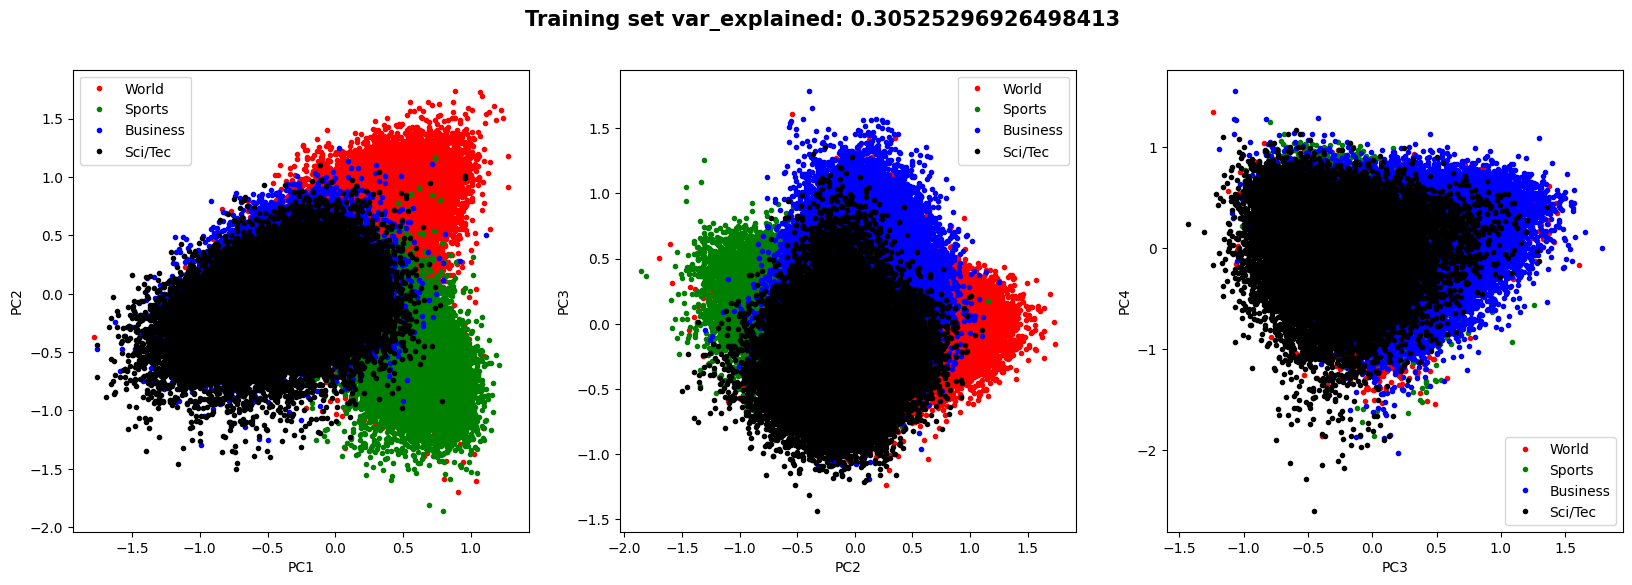

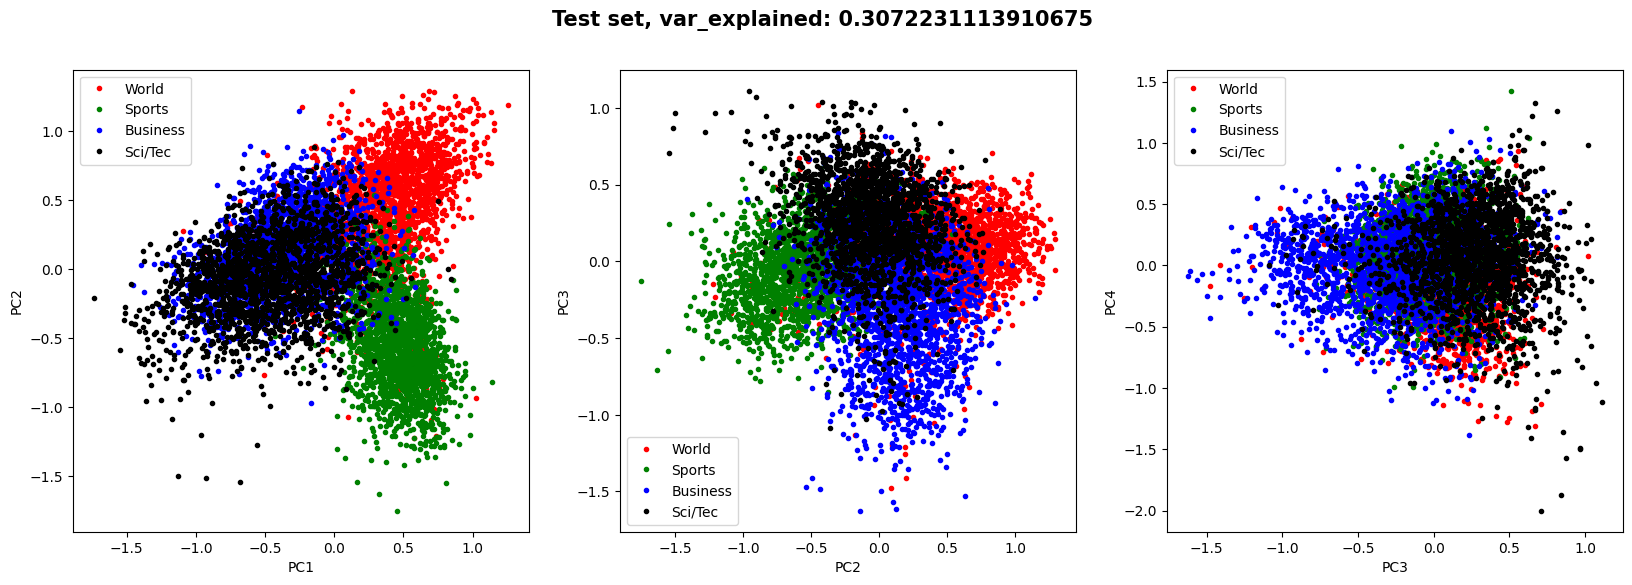

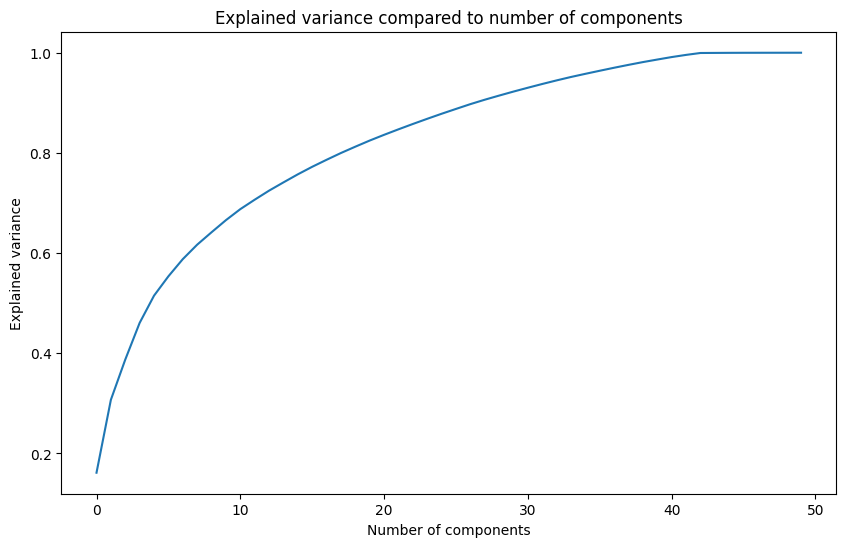

In [20]:
def plot_pca(n_components, feats_train, feats_test, train_labels, test_labels, label_names):
    """
    Does PCA with n_components on given features and plots the result in two dimensions

    Args:
        n_components (int): How many components to use in the PCA
        feats_train (np.ndarray): Average embedding vectors for each text in the training set
        feats_test (np.ndarray): Average embedding vectors for each text in the test set
        train_labels (np.ndarray): Labels for each text in the training set
        test_labels (np.ndarray): Labels for each text in the test set
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
    """

    pca = PCA(n_components=n_components)

    # fit_transform avoids having to manually transform the vectors with the matrix afterwards
    Vtrain = pca.fit_transform(feats_train)
    Vtrain_var_explained = pca.explained_variance_ratio_

    Vtest = pca.fit_transform(feats_test)
    Vtest_var_explained = pca.explained_variance_ratio_

    colors = 'rgbk'
    for label, transformed_vector, title in zip([train_labels, test_labels], [Vtrain, Vtest], [f'Training set var_explained: {sum(Vtrain_var_explained[:2])}', f'Test set, var_explained: {sum(Vtest_var_explained[:2])}']):
        plt.figure(figsize=(20, 6))
        plt.subplot(1, 3, 1)
        for i in range(4):
            plt.plot(transformed_vector[label==i, 0], transformed_vector[label==i, 1], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC1')
        plt.ylabel('PC2')

        plt.subplot(1, 3, 2)
        for i in range(4):
            plt.plot(transformed_vector[label==i, 1], transformed_vector[label==i, 2], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC2')
        plt.ylabel('PC3')

        plt.subplot(1, 3, 3)
        for i in range(4):
            plt.plot(transformed_vector[label==i, 2], transformed_vector[label==i, 3], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC3')
        plt.ylabel('PC4')
        plt.suptitle(title, fontweight='bold', fontsize=15)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(list(range(n_components)),np.cumsum(pca.explained_variance_ratio_))
    plt.title("Explained variance compared to number of components")
    plt.xlabel("Number of components")
    plt.ylabel("Explained variance")
    plt.show()
    
    return pca

n_components = 50
pca_word_vec = plot_pca(n_components, feats_train, feats_test, train_labels, test_labels, ag_news_labels)



### 4.2 PCA projection

**1. Complete the function below to get a word vector a word and project it to a given PCA with n principal components**

**2. Comment on the plot created two cells below. Do the vectors correspond to what you'd expect?**

$\dots$

**3. What must we be cognisant of when doing PCA plots like this on $n$ principal components?**

$\dots$

In [21]:
def get_vector_transform(word, model, pca, n=2):
    """
    Gets the PCA transformed vector of a given word in the model with n principal components

    Args:
        word (str): word to first get the embedding vector of and then project to PCA space
        model (dict, fasttext model): Either a fasttext model or GloVe dictionary
        pca (sklearn.decomposition.PCA): PCA for the model given, should be the same model as the one used to get the vectors
        n (int, optional): Number of princpal components to project to. Defaults to 2.

    Returns:
        np.ndarray: Word vector of word projected to PCA space with n principal components
    """
    # Get the word vector from the model (glove or Fasttext)
    word_vec = model[word]
    # Reshape so it fits with PCA transform
    word_vec = word_vec.reshape(1, -1)

    # Return the PCA transformed vector with n principal components
    ...

TypeError: 'NoneType' object is not subscriptable

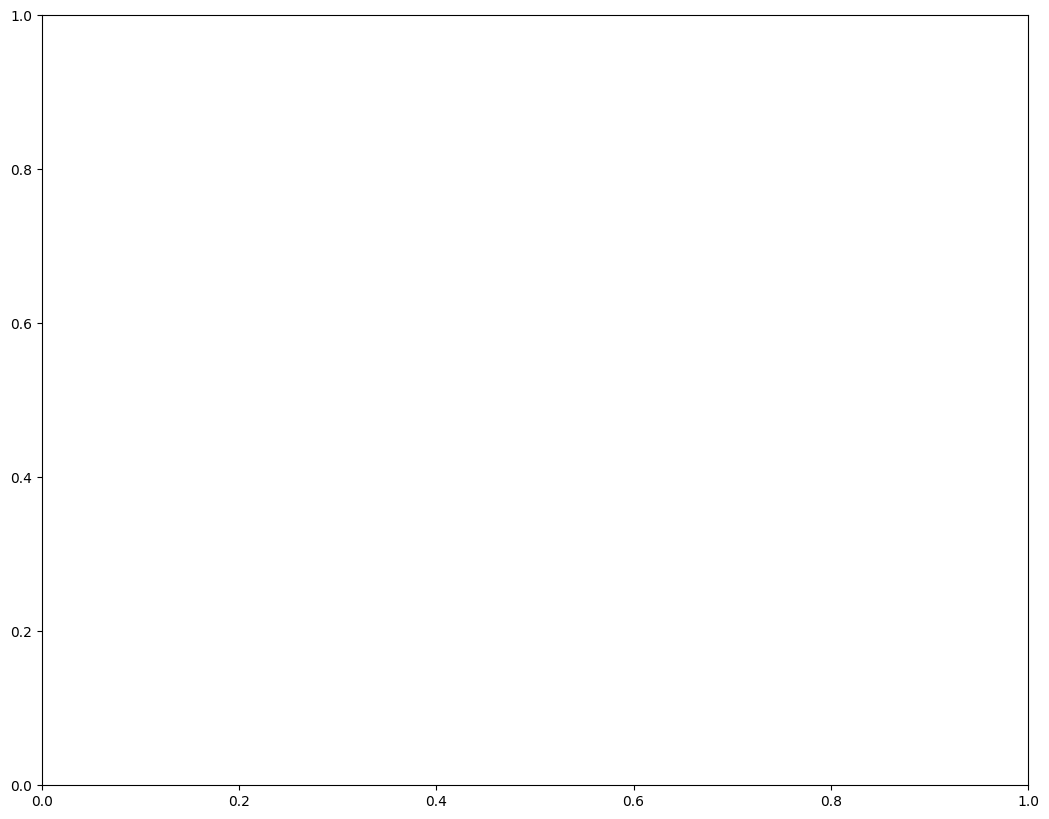

In [22]:
words = ['company', 'business', 'cat', 'software', 'microsoft', 'mouse']

transformed_word_vectors = [get_vector_transform(i, current_model, pca_word_vec, n=2) for i in words]
plt.figure(figsize=(28, 10))
ax = plt.subplot(1, 2, 1)
for idx, vec in enumerate(transformed_word_vectors):
    plt.plot([0, vec[0]], [0, vec[1]], 'b--')
    circle = plt.Circle((vec[0], vec[1]), radius=0.015)
    ax.add_patch(circle)
    label = ax.annotate(words[idx], xy=(vec[0], vec[1]), fontsize=20, ha="center", va="center")

plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')

### 4.3 Comparing with more principal components

**1. Run the cell below to compare different words to the previous list of words. How do they compare? Do these comparisons change significantly when you run with more principal components?**

$\dots$

In [ ]:
n = 2

to_compare = ['software', 'business', 'world'] # Three words, that should be labeled as three different things
for word in words:
    for comparison in to_compare:
        distance = word_similarity(
                                    vec1=get_vector_transform(word, current_model, pca_word_vec, n=2),
                                    vec2=get_vector_transform(comparison, current_model, pca_word_vec,n=2),
                                    glove=None
                                    )
        print(f"{word}-{comparison}: {distance}")
    print()

## Exercise 5 Screwing around with fasttext models

*A good thing if we want to use fasttext on a character level, is that it will be able to understand spelling errors. We're going to test this now by replacing a bunch of letters in our test set randomly with other words and once more test the accuracy of the word-wise fasttext vs the character-wise fasttext*

In [ ]:
def dyslexibot(test_set: list, p=0.05, extra_scuffed=False):
    """
    tHe AlMiGhTy dyslexibot(tm) replaces letters with probability p
    extra_scuffed does what it says: it makes the replacements even harder to guess
    This function is pretty ineffective, if you want to spruce it up, you are welcome to do so
    """

    if extra_scuffed:
        test_set_letters = np.array(list(set(''.join(test_texts)))) # Can replace with all letters currently in test set
    else:
        test_set_letters = np.array(list(string.ascii_lowercase)) # Can only replace with lowercase letters

    new_test_set = [text.split(' ') for text in test_set.copy()]

    print("Replacing text")
    for i, text in tqdm(enumerate(new_test_set)):
        for r, word in enumerate(text):
            word = list(word)
            for t, letter in enumerate(word):
                rand = random.uniform(0, 1)

                if extra_scuffed and rand < p: # We replace even spaces!
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

                elif letter != ' ' and rand < p:
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

            text[r] = ''.join(word)
        new_test_set[i] = ' '.join(text)
    return np.array(new_test_set)

In [ ]:
# Showing that dyslexibot works
text = ["have you heard of the tragedy of darth plagueis the wise"]
print(dyslexibot(text, p=0.10, extra_scuffed=False))

### 5.1 Dyslexibot and fasttext

**1. Test both the fasttext_word_model and the fasttext_char_model on text generated by dyslexibot. Change the $p$ value and perhaps the $\text{extra scuffed}$ option. Try to make the fasttext_word_model as bad as possible while the fasttext_char_model still keeps somewhat good performance. Comment on what you did to achieve this.**

$\dots$

In [ ]:
dyslexitext = dyslexibot(test_texts, p=0.20, extra_scuffed=False)

# Insert your training loop here to calculate the test accuracy on the dyslexitext
# using both the word-wise fasttext and the character-wise fasttext


print("Testing fasttext word model...")
test_fasttext_model(fasttext_word_model, dyslexitext, test_labels, ag_news_labels)

print("\nTesting fasttext character model...")
test_fasttext_model(fasttext_char_model, dyslexitext, test_labels, ag_news_labels)
print()


# # TODO: What it says one line above
# ???????????
# ???????????
# ???????????
# raise NotImplementedError("Test me")

### 5.2 Custom text classification

**1. Finally, to show the robustness of fasttext (and for fun), you are to make your own text and try to let fasttext classify this as one of the four models. Rememeber that the original dataset used texts of around 240 words, so you can either experiment with texts shorter or longer than this and see whether the accuracy is significantly different.**

**As an extra challenge, you can try to create a text which is as close to the model's decision boundary as possible, IE. one that is as close as possible to being classified as either two or more of the classes**

In [ ]:
own_text = ""

assert own_text != "", "Come on, be creative"

print("The text is classified as: ", fasttext_word_model.predict(own_text))#[0][0][9:])

##  $\star$ $\star$ $\star$ Exercise 6 Extremely optional task

**1. It's quite a waste to have all those juicy principle components of the embedding matrices without using them in a classifier of some sort, right?**

**Create a classifier to classify texts as one of the four labels, based on the projections of their words unto a number of the principle components of the embedding matrices. Compare this classifier to the fasttext classifier and reflect on their performance.**

In [ ]:
raise NotImplementedError("Asking for a whole classifier is a bit much, no?")